## INITIALIZATION

In [1]:
%matplotlib notebook
import numpy as np
import time
import tables as tb
import matplotlib.pyplot as plt

from tjmonopix.tjmonopix import TJMonoPix
from tjmonopix.online_monitor import noise_monitor, plots
from tjmonopix.analysis import analysis_functions

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml", no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45


2022-02-08 12:03:11,569 [INFO ] (MainThread) GPAC: power reset
2022-02-08 12:03:13,305 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-02-08 12:03:13,529 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-02-08 12:03:13,775 [INFO ] (MainThread) ibias = 45
2022-02-08 12:03:13,790 [INFO ] (MainThread) ibias = 503.125 nA
2022-02-08 12:03:14,361 [INFO ] (MainThread) {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8059798142570278, 'VDDP OC': False, 'VDDA [mA]': 50.151368865825674, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0622801785996314, 'VDDD OC': False, 'VPC [mA]': -0.11449949028793859, 'VPCSWSF [mA]': 0.14157025259013375, 'VDDA [V]': 1.8058565495495498, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10059447096451782}


## POWER STATUS

In [2]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
chip.get_power_status()

{'BiasSF [V]': 1.062780289971045,
 'BiasSF [mA]': 0.10059447096451782,
 'VDDA OC': False,
 'VDDA [V]': 1.8058565495495498,
 'VDDA [mA]': 50.151368865825674,
 'VDDA_DAC OC': False,
 'VDDA_DAC [V]': 1.8035484515484517,
 'VDDA_DAC [mA]': 2.502471747485684,
 'VDDD OC': False,
 'VDDD [V]': 1.8015140363636364,
 'VDDD [mA]': 2.820288999038665e-08,
 'VDDP OC': False,
 'VDDP [V]': 1.8059798142570278,
 'VDDP [mA]': 128.39714805315754,
 'VPC [V]': 1.2998506463536463,
 'VPC [mA]': -0.29549869292779224,
 'VPCSWSF [V]': 0.5001542395802099,
 'VPCSWSF [mA]': -0.14357123343761902}

In [3]:
# SELECT WHICH DOUBLE COLUMNS (PIXEL "FLAVOURS") TO ENABLE
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_HV'].setall(True)
chip['CONF_SR']['EN_OUT'].setall(False) #ENABLES OR DISABLES THE NORMAL OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['nEN_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['EN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE NORMAL HITOR PADS, HITOR0-3 =  1-4 flavor, ACTIVE LOW
chip['CONF_SR']['nEN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY HITOR PADS, ACTIVE LOW
chip.write_conf()

# SELECT WHICH PHYSICAL COLUMS TO INJECT
# INJ_IN_MON_L AND INJ_IN_MON_L SELECT THE LEFT AND RIGHT SPECIAL ANALOG MONITORING PIXELS
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)

chip['CONF_SR']['INJ_IN_MON_L'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS LEFT SIDE
chip['CONF_SR']['INJ_IN_MON_R'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS RIGHT SIDE

# SELECT WHICH PHYSICAL ROWS TO INJECT
# THE SPEXIAL PIXELS OUTA_MON3 to OUTA_MON0 CORRESPONT TO ROWS 223 to 220 FOR INJECTION
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['INJ_ROW'][223:220] = True # FOR THE ANALOG MONITORING TOP PIXEL

# SELECT PHYSICAL COLUMNS AND ROWS FOR INJECTION WITH FUNCTION
#chip.enable_injection(3,18,99)
chip.write_conf()


# SELECT PHYSICAL COLUMN(S) FOR HITOR OUTPUT
# nMASKH (SO SETTING MASKH TO FALSE) ENABLES HITOR FOR THE SPECIFIC ROW
chip['CONF_SR']['DIG_MON_SEL'].setall(False)
#chip.enable_column_hitor(1,18)

chip.write_conf()

## ANALOG FRONT END CONFIGURATION

In [4]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator. It is changed later.
ibias_dac = 100

## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-  
CAPCAL=20.3439450687
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-02-08 12:03:23,305 [INFO ] (MainThread) vl = 0.951929133858V
2022-02-08 12:03:23,321 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-08 12:03:23,335 [INFO ] (MainThread) vreset = 1.05106299213V
2022-02-08 12:03:23,351 [INFO ] (MainThread) icasn = 0
2022-02-08 12:03:23,368 [INFO ] (MainThread) icasn = 4.375 nA
2022-02-08 12:03:23,390 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-02-08 12:03:23,467 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-02-08 12:03:23,490 [INFO ] (MainThread) ithr = 5
2022-02-08 12:03:23,506 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-02-08 12:03:23,520 [INFO ] (MainThread) idb = 50
2022-02-08 12:03:23,536 [INFO ] (MainThread) idb = 892.5 nA
2022-02-08 12:03:23,552 [INFO ] (MainThread) ibias = 100
2022-02-08 12:03:23,568 [INFO ] (MainThread) ibias = 1104.6875 nA


## ENABLE MASK AND GET OCCUPANCY

In [5]:
th = 2
step = 50
dt = 0.2

noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
print("========= Getting residual occupancy =============")
pix_tmp, cnt = chip.get_occupancy(dt);

Enable MASKH 50
Got 50613 hits, total noisy pixels: 32
Enable MASKH 100
Got 106823 hits, total noisy pixels: 92
Enable MASKH 150
Got 28591 hits, total noisy pixels: 139
Enable MASKH 200
Got 160478 hits, total noisy pixels: 213
Enable MASKH 223
Got 38690 hits, total noisy pixels: 236
Enable MASKV 50
Got 9 hits, total noisy pixels: 237
Enable MASKV 100
Got 108 hits, total noisy pixels: 237
Enable MASKV 111
Got 14 hits, total noisy pixels: 238
Enable MASKD 50
Got 90 hits, total noisy pixels: 240
Enable MASKD 100
Got 11 hits, total noisy pixels: 240
Enable MASKD 150
Got 107 hits, total noisy pixels: 242
Enable MASKD 200
Got 104 hits, total noisy pixels: 244
Enable MASKD 250
Got 12 hits, total noisy pixels: 246
Enable MASKD 300
Got 46 hits, total noisy pixels: 247
Enable MASKD 350
Got 22 hits, total noisy pixels: 252
Enable MASKD 400
Got 14 hits, total noisy pixels: 254
Enable MASKD 447
Got 119 hits, total noisy pixels: 256
Checking again after masking
Got 126 hits, total noisy pixels: 258


# Configure injection and Select 1pixel 

2022-02-08 12:03:38,253 [INFO ] (MainThread) idb = 50
2022-02-08 12:03:38,269 [INFO ] (MainThread) idb = 892.5 nA
2022-02-08 12:03:38,283 [INFO ] (MainThread) vh = 1.80232283465V


(18, 25)
Got 115 hits in 0.2 s


<IPython.core.display.Javascript object>


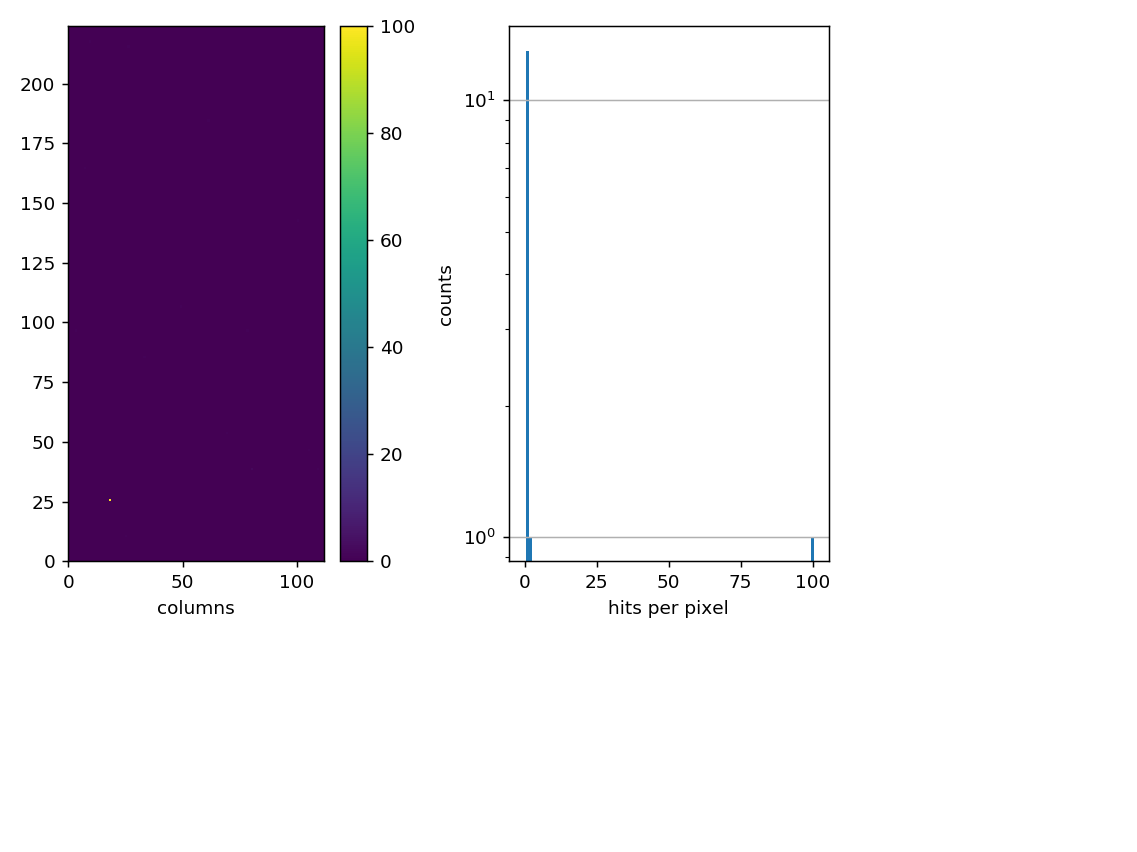

2022-02-08 12:03:40,809 [WARNI] (MainThread) Deprecated: Use get_FIFO_SIZE()


fifo size 1368
0 (18, 25) 100
1 (77, 190) 2
2 (8, 178) 2
3 (107, 119) 1
4 (84, 75) 1
5 (67, 147) 1
6 (67, 32) 1
7 (62, 181) 1
8 (44, 56) 1
9 (33, 85) 1
10 (26, 215) 1
11 (25, 10) 1
12 (9, 149) 1


In [6]:
delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

"""
possiamo cancellare?
chip['CONF_SR']['MASKV'].setall(False)
chip['CONF_SR']['MASKH'].setall(False)
chip['CONF_SR']['MASKD'].setall(False)
chip['CONF_SR']['MASKH'][row_to_inject]=True
chip['CONF_SR']['EN_HV'].setall(False)         #all'inizio è setall(true)
chip['CONF_SR']['EN_HV'][col_to_inject//2]=True

"""
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)

for col_to_inject in [18]:
    #col_to_inject = 40
    row_to_inject = 25
    #chip['CONF_SR']['INJ_ROW'].setall(True)
    #chip['CONF_SR']['COL_PULSE_SEL'][col_to_inject] = True#.setall(False)
    chip.enable_injection(3, col_to_inject, row_to_inject)
    print(col_to_inject, row_to_inject)
    chip.write_conf()

    idb = chip.set_idb_dacunits(50,1) #### threshold; SOPRA LA METTE CON 50 DAC
    vh = chip.set_vh_dacunits(100,1) #### injection; SOPRA LA METTE CON 80 DAC
    chip.write_conf()

    _, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
    chip['data_rx'].set_en(False)

    chip.set_monoread()
    for _ in range(5):
        chip['fifo'].reset()
        time.sleep(0.002)
    chip["inj"].start()
    while not chip['inj'].is_ready:
        time.sleep(0.001)
    time.sleep(0.2)

    print "fifo size", chip['fifo'].get_fifo_size()
    ix = chip.interpret_data(chip['fifo'].get_data())
    uni, cnt = np.unique(ix[["col","row"]], return_counts = True)
    arg = np.argsort(cnt)
    for a_i, a in enumerate(arg[::-1]):
        print a_i, uni[a], cnt[a]
        

# Threshold scan
## step by step

In [7]:
col_to_inject = 18
row_to_inject = 25
idb_dac = 20
idb = chip.set_idb_dacunits(idb_dac, 1)
chip.write_conf()
    
injlist = np.arange(80, 0, -1)
inj_low_dac = chip.get_vl_dacunits()
cnt, tot, inj_high = chip.injection_scan(injlist, inj_low_dac, col_to_inject, row_to_inject)


2022-02-08 12:03:45,177 [INFO ] (MainThread) idb = 20
2022-02-08 12:03:45,191 [INFO ] (MainThread) idb = 367.5 nA


inj[dac] inj[V] len(ix), len(ix_inj) aveToT
80 2.08578740157 38690 54 50.01851851851852
79 2.07161417323 38812 52 49.63461538461539
78 2.05744094488 30295 52 47.65384615384615
77 2.04326771654 32120 51 50.27450980392157
76 2.02909448819 39420 51 49.431372549019606
75 2.01492125984 31512 50 47.96
74 2.0007480315 37595 49 50.0
73 1.98657480315 31512 51 49.01960784313726
72 1.9724015748 39420 52 48.59615384615385
71 1.95822834646 32120 48 49.5
70 1.94405511811 31512 50 50.36
69 1.92988188976 30904 51 49.92156862745098
68 1.91570866142 39420 50 49.64
67 1.90153543307 38204 50 47.62
66 1.88736220472 31512 53 47.735849056603776
65 1.87318897638 31512 50 48.94
64 1.85901574803 31586 50 47.92
63 1.84484251969 35162 54 48.370370370370374
62 1.83066929134 31512 50 47.78
61 1.81649606299 32120 48 46.1875
60 1.80232283465 32120 51 45.666666666666664
59 1.7881496063 38812 52 45.76923076923077
58 1.77397637795 32120 51 44.490196078431374
57 1.75980314961 31512 48 44.229166666666664
56 1.74562992126 

C:\ProgramData\Miniconda2\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Miniconda2\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


11 1.10783464567 32120 0 nan
10 1.09366141732 31512 0 nan
9 1.07948818898 31512 0 nan
8 1.06531496063 31512 0 nan
7 1.05114173228 38812 0 nan
6 1.03696850394 31512 0 nan
5 1.02279527559 31512 0 nan
4 1.00862204724 38812 0 nan
3 0.994448818898 31512 0 nan
2 0.980275590551 32120 0 nan
1 0.966102362205 38204 0 nan


approx. th = 14 DAC = 1.026 V = 1400 e-
sigma 3 DAC = 0.220 V = 300 e-


<IPython.core.display.Javascript object>


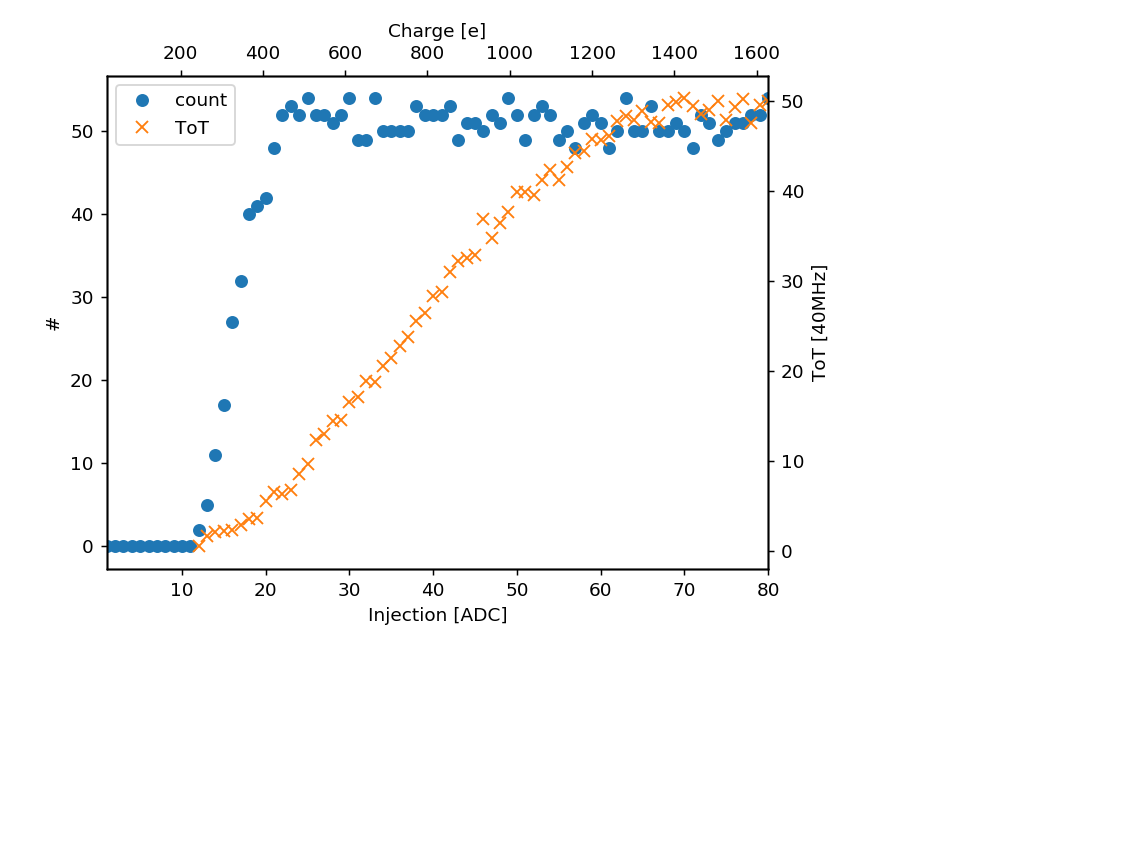

In [8]:
analysis_functions.find_approx_threshold(injlist, inj_high, cnt, repeat, CAPCAL)
plots.s_curve(injlist, cnt, tot, CAPCAL);

## run threshold scan using injection_scan

In [13]:
chip.set_vh_dacunits(80,1)  # The functions below change vl w.r.t. vh
chip.set_idb_dacunits(20,1)
col_to_inject = 18
row_to_inject = 25

import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans = tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

injlist = np.arange(40,0,-1)
output_filename = scans.start(
    collist = [col_to_inject], rowlist = [row_to_inject],
    injlist = injlist, thlist = None, phaselist = None,
    with_mon = False, n_mask_col = 10, debug = 2)

scans.analyze(output_filename)
'''fev = scans.output_filename[:-4]+"ev.h5"
with tb.open_file(fev) as f:
    hits = f.root.Hits[:]
print len(hits)

uni, u_cnt = np.unique(hits["inj"], return_counts=True)
data = np.zeros(len(injlist))
for u_i, u in enumerate(uni):
    a = np.argmin(np.abs(injlist - u))
    data[a] = u_cnt[u_i]

plt.figure()
plt.plot(injlist, data,"C1o", label = "fast scan (this one)")
#plt.plot(injlist, cnt,"C0.-", label = "step by step (prev. cell)") ### step by step
plt.xlabel("Injection [DAC]")
plt.ylabel("Counts")
plt.legend();'''

2022-02-08 12:20:48,019 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-08 12:20:48,036 [INFO ] (MainThread) idb = 20
2022-02-08 12:20:48,051 [INFO ] (MainThread) idb = 367.5 nA
2022-02-08 12:20:48,066 [INFO ] (MainThread) Initializing InjectionScan
2022-02-08 12:20:48,637 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2993515804695306, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 79.53297889485958, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 142.99917665269473, 'BiasSF [V]': 1.0647807354566992, 'VDDD OC': False, 'VPC [mA]': -0.09049959601525082, 'VPCSWSF [mA]': 0.0035017435661692446, 'VDDA [V]': 1.8048574894894895, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8045472377622378, 'BiasSF [mA]': 0.10059447096451782}
2022-02-08 12:20:48,721 [INFO ] (MainThread) Temperature (C): 30.173702
2022-02-08 12:20:48,783 [INFO ] (MainThread) Temperature (C): 3

2022-02-08 12:20:52,546 [INFO ] (MainThread) scan_param_id=0 dat=116736: th=20 inj=13 phase=0 row=25
2022-02-08 12:20:52,546 [ERROR] (WatchdogThread) DATA RX FIFO discard error(s) detected
2022-02-08 12:20:52,594 [ERROR] (WatchdogThread) DATA RX FIFO discard error(s) detected
2022-02-08 12:20:52,594 [INFO ] (MainThread) scan_param_id=0 dat=86016: th=20 inj=12 phase=0 row=25
2022-02-08 12:20:52,647 [ERROR] (WatchdogThread) DATA RX FIFO discard error(s) detected
2022-02-08 12:20:52,677 [INFO ] (MainThread) scan_param_id=0 dat=182272: th=20 inj=11 phase=0 row=25
2022-02-08 12:20:52,694 [ERROR] (WatchdogThread) DATA RX FIFO discard error(s) detected
2022-02-08 12:20:52,746 [INFO ] (MainThread) scan_param_id=0 dat=153600: th=20 inj=10 phase=0 row=25
2022-02-08 12:20:52,746 [ERROR] (WatchdogThread) DATA RX FIFO discard error(s) detected
2022-02-08 12:20:52,793 [INFO ] (MainThread) scan_param_id=0 dat=86016: th=20 inj=9 phase=0 row=25
2022-02-08 12:20:52,793 [ERROR] (WatchdogThread) DATA RX F

0 35154592 100.000% 0.401s 11923167hits 0errs
data (inj_n 100,inj_loop 40): INJ=4000 MONO=9996000 MON=0
0 1986801 16.663% 63.574s 1608670hits 0errs
data (inj_n 100,inj_loop 40): INJ=1 MONO=9936365 MON=0


KeyboardInterrupt: 

# Global TH scan

In [ ]:
inj_height_dac = 21  # On the threshold

chip.set_vl_dacunits(40,0)
chip.set_vh_dacunits(40+inj_height_dac,0)
chip.write_conf()

for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)

# ## step by step 
# if False:
#     cnt=np.empty(len(thlist))
#     print "inj all_hits hits aveToT"
#     for th_i,th in enumerate(thlist):
#         chip.set_idb_dacunits(th,0)
#         chip.write_conf()
#         for _ in range(5):
#             chip['fifo'].reset()
#             time.sleep(0.002)
#         chip.set_monoread()
#         chip["inj"].start()
#         while not chip['inj'].is_ready:
#             time.sleep(0.001)
#         time.sleep(0.2)
#         x = chip['fifo'].get_data()
#         ix = chip.interpret_data(x)
#         ix_inj=ix[np.bitwise_and(ix["col"]==col_to_inject, ix["row"]==row_to_inject)]
#         print th,len(ix),len(ix_inj),np.average((ix_inj["te"]-ix_inj["le"]) & 0x3F)
#         cnt[th_i]=len(ix_inj)
#     plt.plot(thlist,cnt,"C0.-",label="step by step")
    
## fast scan
thlist = np.arange(50,0,-1)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)
output_filename=scans.start(
    collist=[col_to_inject], rowlist=[row_to_inject],
    injlist=None, thlist=thlist, phaselist=None,
    with_mon=False, n_mask_col=1, debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
with tb.open_file(fev) as f:
    hits=f.root.Hits[:]
print len(hits),
hits=hits[np.bitwise_and(hits["col"]==col_to_inject,hits["row"]==row_to_inject)]
print len(hits)

uni,u_cnt=np.unique(hits["th"],return_counts=True)
data=np.zeros(len(thlist))
for u_i,u in enumerate(uni):
    a=np.argmin(np.abs(thlist-u))
    data[a]=u_cnt[u_i]
gl_th=thlist[np.argmin(np.abs(data-50))]
print "gl_th",gl_th

plt.figure()
plt.plot(thlist,data,"C1.",label="fast scan")
plt.xlabel("IDB [DAC] $\\propto$ disciminator threshold")
plt.ylabel("Counts")
plt.legend()

# phase scan

In [ ]:
#gl_th=4 ## from gl_th scan
chip.set_vl_dacunits(40,0)
chip.set_vh_dacunits(80+40,0)
chip.set_idb_dacunits(gl_th,0)
chip.write_conf()

phaselist=np.arange(0,48,1)
import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)
output_filename=scans.start(
    collist=[col_to_inject], rowlist=[row_to_inject],
    injlist=None, thlist=None, phaselist=phaselist,
    with_mon=False, n_mask_col=1, debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
fraw=scans.output_filename+".h5"
import tjmonopix.analysis.analyze_hits as analyze_hits
reload(analyze_hits)
ana=analyze_hits.AnalyzeHits(fev,fraw)
ana.init_hist_ev()
ana.init_cnts()
ana.init_le_hist()
ana.init_le_cnts()
ana.run()

import tjmonopix.analysis.analyze_le_cnts as analyze_le_cnts
ana=analyze_le_cnts.AnalyzeLECnts(fev,fraw)
ana.init_best_phase()
ana.run()
with tb.open_file(fev) as f:
    phase=f.root.BestPhase[0]["phase"]
with tb.open_file(fev) as f:
    hits=f.root.LEHist[:]
plt.imshow(np.transpose(hits[0]["LE"]),origin="bottom left",aspect="auto")
plt.plot([phase,phase],[0,63],"w--")
plt.ylim(0,63)
plt.colorbar()

In [ ]:
#gl_th=4
#phase=6
chip.set_vl_dacunits(40,0)
chip.set_idb_dacunits(gl_th,0)
chip.write_conf()
chip["inj"].set_phase(phase)

import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

pix=[3, col_to_inject, row_to_inject]
injlist=np.arange(1,80,1)
thlist= None #np.arange(80,20,-1)
phaselist=None
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
fraw=scans.output_filename+".h5"
import tjmonopix.analysis.analyze_hits as analyze_hits
reload(analyze_hits)
ana=analyze_hits.AnalyzeHits(fev,fraw)
ana.init_apply_ts_inj_window()
ana.init_delete_noninjected()
ana.init_hist_ev()
ana.init_cnts()
ana.init_le_hist()
ana.init_le_cnts()
ana.run()

import tjmonopix.analysis.analyze_cnts as analyze_cnts
ana=analyze_cnts.AnalyzeCnts(fev,fraw)
ana.init_scurve_fit()
ana.run()

import tjmonopix.analysis.analyze_le_cnts as analyze_le_cnts
reload(analyze_le_cnts)
ana=analyze_le_cnts.AnalyzeLECnts(fev,fraw)
ana.init_scurve_fit()
ana.run()

In [ ]:
with tb.open_file(fev) as f:
    le=f.root.LECnts[:]
    le_fit=f.root.LEScurveFit[:]
    cnt=f.root.Cnts[:]
    cnt_fit=f.root.ScurveFit[:]
fig,ax=plt.subplots(1,1)
import tjmonopix.analysis.utils as utils
x=np.append(np.arange(1,np.min(cnt["inj"])),cnt["inj"])
y=np.append(np.zeros(len(x)-len(cnt["cnt"])),cnt["cnt"])
ax.plot(x,y,"C0.",label="all")
A=cnt_fit[0]["A"]
mu=cnt_fit[0]["mu"]
sigma=cnt_fit[0]["sigma"]
x,y=utils.scurve_from_fit(x,A_fit=A,mu_fit=mu,sigma_fit=sigma,reverse=False)
ax.plot(x,y,"C0-")
print "all mu %.3f ADU (%.2f e) sigma %.3f ADU (%.2f e)"%(mu,mu*CAPCAL,sigma,sigma*CAPCAL)

tmp=le[le["toa"]==12]
x=np.append(np.arange(1,np.min(tmp["inj"])),tmp["inj"])
y=np.append(np.zeros(len(x)-len(tmp["cnt"])),tmp["cnt"])
ax.plot(x,y,"C1.",label="in-time")
A=le_fit[le_fit["toa"]==12][0]["A"]
mu_in=le_fit[le_fit["toa"]==12][0]["mu"]
sigma_in=le_fit[le_fit["toa"]==12][0]["sigma"]
x,y=utils.scurve_from_fit(x,A_fit=A,mu_fit=mu_in,sigma_fit=sigma_in,reverse=False)
ax.plot(x,y,"C1-")
ax.set_xbound(0,np.max(cnt["inj"]))
ax2=ax.twiny()
ax2.set_xbound(0,np.max(cnt["inj"])*CAPCAL)
ax.set_xlabel("Injection [ADU]")
ax2.set_xlabel("Charge [e]")
ax.set_ylabel("#")
print "intime mu %.3f ADU (%.2f e) sigma %.3f ADU (%.2f e)"%(mu_in,mu_in*CAPCAL,sigma_in,sigma_in*CAPCAL)
print "over drive %.3f ADU (%.2f e)"%(mu_in-mu, (mu_in-mu)*CAPCAL)
ax.legend()